# The London Railway Network

The cell below defines the abstract class whose API you will need to impement. Do NOT modify it.

In [29]:

from abc import ABC, abstractmethod  

class AbstractLondonRailwayMapper(ABC):
    
    # constructor
    @abstractmethod
    def __init__(self):
        pass           
        
    # data initialisation
    @abstractmethod
    def loadStationsAndLines(self):
        pass

    # returns the minimum number of stops to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # numStops : int
    @abstractmethod
    def minStops(self, fromS, toS):     
        numStops = -1
        return numStops    
    
    # returns the minimum distance in miles to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # minDistance : float
    @abstractmethod
    def minDistance(self, fromS, toS):
        minDistance = -1.0
        return minDistance
    
    # given an unordered list of station names, returns a new railway line 
    # (represented as a list of adjacent station names), connecting all such stations 
    # and such that the sum of the distances (in miles) between adjacent stations is minimised
    # inputList : set<str>
    # outputList : list<str>
    @abstractmethod
    def newRailwayLine(self, inputList):
        outputList = []
        return outputList

In [30]:
from math import radians, cos, sin, asin, sqrt

"""
------The haversine function below has been copied from this source:
------https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
"""

def haversine(coordinate1, coordinate2):

    lon1, lat1, lon2, lat2 = map(radians, [coordinate1[1], coordinate1[0], coordinate2[1], coordinate2[0]])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956
    return c * r

"""
------This queue data structure is used to support the BFS algorithm (which was used to implement the minStops function).
"""
class Queue:
    
    def __init__(self):
        self.queue = []
        self.index = 0

    def enqueue(self, element):
        self.queue.append(element)
    
    def dequeue(self):
        first_element = self.queue[self.index]
        self.queue[self.index] = None
        self.index += 1
        return first_element

"""
------This min-oriented priority queue data structure is used to support the Djikstra algorithm (which was used to implement the minDist function).
------The implementation of the binary heap was inspred from here: https://www.youtube.com/watch?v=t0Cq6tVNRBA&t

"""
class MinPQBinaryHeap:

    def __init__(self):
        self.list = []
        self.node_index_dict = {}
    
    def get_right_child(self, parent_node_index):
        return self.list[2*parent_node_index +2]

    def get_left_child(self, parent_node_index):
        return self.list[2*parent_node_index +1]

    def get_parent(self, child_node_index):
        return self.list[int((child_node_index-1)/2)]

    def has_right_child(self, parent_node_index):
        return ((2*parent_node_index +2)<len(self.list))

    def has_left_child(self, parent_node_index):
        return ((2*parent_node_index +1)<len(self.list))
    
    def has_parent(self, child_node_index):
        return (((child_node_index-1)/2)>=0)

    def swap(self, index1, index2):
        self.node_index_dict[self.list[index1][0]] = index2
        self.node_index_dict[self.list[index2][0]] = index1
        temp = self.list[index1]
        self.list[index1] = self.list[index2]
        self.list[index2] = temp

    def insert(self, node_name, weight):
        t = [node_name, weight]
        self.list.append(t)
        self.node_index_dict[node_name] = len(self.list)-1
        self.heapify_up()
        
    def delete_min(self):
        min_item = self.list[0]
        self.node_index_dict.pop(min_item[0])
        self.list[0] = self.list[len(self.list)-1]
        self.list.pop()
        if (not (len(self.list) == 0)):
            self.node_index_dict[self.list[0][0]] = 0
        self.heapify_down(0)
        return min_item[0]

    def decrease_key_of(self, node_name, new_weight):
        index = self.node_index_dict[node_name]
        self.list[index][1] = new_weight
        self.heapify_down(index)
    
    #------The following heapify operations restore heap order if they are violated after the insert/delete_min or decrease_key operations
    def heapify_down(self, index):
        
        while (self.has_left_child(index)):
            smallest_child_index = int(2*index +1)
            if (self.has_right_child(index) and (self.get_right_child(index)[1] < self.get_left_child(index)[1])):
                smallest_child_index = int(2*index + 2)
            if(self.list[index][1] < self.list[smallest_child_index][1]):
                index = smallest_child_index
                continue
            else:
                self.swap(index, smallest_child_index)

            index = smallest_child_index

    def heapify_up(self):
        index = len(self.list)-1
        while (self.has_parent(index) and (self.get_parent(index)[1] > self.list[index][1])):
            self.swap(index, int((index-1)/2))
            index = int((index-1)/2)
            
    def contains(self, node_name):
        if node_name in self.node_index_dict:
            return True
        else:
            return False

    def is_empty(self):
        return (len(self.list) == 0)

"""
------The Railway network is represented using an undirected weighted graph.
"""
class Edge:

    def __init__(self, name, v, w, weight):
        self.v = v
        self.w = w
        self.name = name
        self.weight = weight
    
    def end_point(self):
        return self.v

    def other_end_point(self, vertex):
        if (vertex == self.v):
            return self.w
        else:
            return self.v

    def compare_edge(self, e):
        if(self.weight < e.weight):
            return -1
        elif(self.weight > e.weight):
            return 1
        else:
            return 0

class WeightedUndirectedGraph:

    def __init__(self):
        self.adjacency_dictionary = {}
        self.stations_coordinates = {}
        self.station_names = []
        self.no_of_vertices = 0
        
    def add_vertex(self, station_name, coordinates):
        self.adjacency_dictionary[station_name] = []
        self.stations_coordinates[station_name] = coordinates

    def add_edge(self, e):
        v = e.end_point()
        w = e.other_end_point(v)
        self.adjacency_dictionary[v].append(e)
        self.adjacency_dictionary[w].append(e)

"""
------The BFS algorithm was used to support minStops.
"""
class BFSMinStops:

    def __init__(self, graph, source, dest):
        self.graph = graph
        self.source = source
        self.dest = dest
        self.path = []
        self.dist_from_source = [-1 for _ in range(0,self.graph.no_of_vertices)]
        self.edge_to = [-1 for _ in range(0,self.graph.no_of_vertices)]
    
    #------This function returns the final path length from the source to destination station that has been computed.
    def path_length(self):
        q = Queue()
        q.enqueue(self.source)
        i = self.graph.station_names.index(self.source)
        j = self.graph.station_names.index(self.dest)
        self.dist_from_source[i] = 0
        
        #------While the path length of the destination station hasn't been computed, the algorithm iterates through
        #------the surrounding nodes. The order of the iteration is enforced by the queue.
        while (self.dist_from_source[j] == -1):
            v = q.dequeue()
            self.edge_to[i] = 0

            list2 = self.graph.adjacency_dictionary[v]
            for edge in list2:
                w = edge.other_end_point(v)
                temp_index1 = self.graph.station_names.index(v)
                temp_index2 = self.graph.station_names.index(w)
                
                if (self.dist_from_source[temp_index2] == -1):
                    q.enqueue(w)
                    self.dist_from_source[temp_index2] = self.dist_from_source[temp_index1]+1
                    self.edge_to[temp_index2] = v

        return self.dist_from_source[j]
    
    #------The following function gives path from the source station to the destination station that the algorithm took.
    def station_directions(self):
  
        x = self.dest
        while(x != self.source):
            self.path.insert(0,x)
            x = self.edge_to[self.graph.station_names.index(x)]

        self.path.insert(0,self.source)
        return self.path

"""
-----The Dijkstra algorithm was used to support the minDistance function.
"""
class DijkstraMinDistance():
    
    def __init__(self, graph, source, dest):
        self.graph = graph
        self.source = source
        self.dest = dest
        self.edge_to = [None for _ in range(0,graph.no_of_vertices)]
        self.dist_to = ["inf" for _ in range(0,graph.no_of_vertices)]
        self.source_index = self.graph.station_names.index(self.source)
        self.dest_index = self.graph.station_names.index(self.dest)
        self.dist_to[self.source_index] = 0
        self.pq = MinPQBinaryHeap()
        self.pq.insert(self.source, 0)
    
    #------The algorithms goes to each vertex via its shortest path, and relaxes the edges connected to the vertex when it reaches it.
    def min_path_length(self): 
        while(not self.pq.is_empty()):
            v = self.pq.delete_min()
            if (v == self.dest):
                break
            for edge in self.graph.adjacency_dictionary[v]:
                self.relax(v, edge)
        
        return self.dist_to[self.graph.station_names.index(self.dest)]
    
    #------The process of relaxing an edge:
    def relax(self, v, edge):
        w = edge.other_end_point(v)
        w_index = self.graph.station_names.index(w)
        v_index = self.graph.station_names.index(v)
        if ((self.dist_to[w_index] == "inf") or (self.dist_to[w_index] > self.dist_to[v_index] + edge.weight)) :
            self.dist_to[w_index] = self.dist_to[v_index] + edge.weight
            self.edge_to[w_index] = v
            if (self.pq.contains(w)):
                self.pq.decrease_key_of(w, self.dist_to[w_index])
            else:
                self.pq.insert(w, self.dist_to[w_index])

"""
------The Multi-fragment algorithm was used to support the newRailwayLine function.
"""
class MultiFragment():

    def __init__(self, graph, station_list):
        self.graph = graph
        self.station_list = station_list
        self.reversed_station_list = list(self.station_list)
        self.reversed_station_list.reverse()
        self.list_of_all_possible_edges = []
        self.edge_degree_dictionary = {}
        self.node_tail_dictionary = {}
        self.edges_in_railway_line = []
        self.station_edges_dict = {}
        self.output_list = []
        self.length = 0


        #------The code below creates a list (list_of_all_possible_edges) of all possible edges between the specified stations in station_list,
        #------which is then sorted using merge sort. Edge degree dictionary is also initialised to 0 for every edge. Edge degree is a counter
        #------that keeps track of how many edges a given station has. This can be no more than 2 in order to prevent branching.
        for i in range(len(self.station_list)):
            self.edge_degree_dictionary[self.station_list[i]] = 0
            self.node_tail_dictionary[self.station_list[i]] = self.station_list[i]
            for j in range(len(self.reversed_station_list) - i):
                if (self.station_list[i] == self.reversed_station_list[j]):
                    continue
                weight = haversine(self.graph.stations_coordinates[self.station_list[i]], self.graph.stations_coordinates[self.reversed_station_list[j]])
                current_edge = Edge("newRailwayLine",self.station_list[i], self.reversed_station_list[j], weight)
                self.list_of_all_possible_edges.append(current_edge)
                

        self.merge_sort_list_of_edges(self.list_of_all_possible_edges, 0, (len(self.list_of_all_possible_edges)-1))

    #------The following two functions are the implementation of merge sort, which has been inspired from:
    #------https://www.geeksforgeeks.org/merge-sort/

    def merge_sort_list_of_edges(self, list, left_index, right_index):
        if (left_index >= right_index):
            return
        mid = (left_index+right_index)//2
        self.merge_sort_list_of_edges(self.list_of_all_possible_edges, left_index, mid)
        self.merge_sort_list_of_edges(self.list_of_all_possible_edges, mid+1, right_index)
        self.merge(self.list_of_all_possible_edges, left_index, right_index, mid)


    def merge(self, list, left_index, right_index, mid):
        left_copy = list[left_index:mid+1]
        right_copy = list[mid+1:right_index+1]
        left_copy_index = 0
        right_copy_index = 0
        sorted_index = left_index

        while ((left_copy_index<len(left_copy)) and (right_copy_index<len(right_copy))):

            if (left_copy[left_copy_index].weight <= right_copy[right_copy_index].weight):
                list[sorted_index] = left_copy[left_copy_index]
                left_copy_index += 1
            else:
                list[sorted_index] = right_copy[right_copy_index]
                right_copy_index += 1
            sorted_index += 1

        while (left_copy_index<len(left_copy)):
            list[sorted_index] = left_copy[left_copy_index]
            left_copy_index += 1
            sorted_index += 1

        while (right_copy_index<len(right_copy)):
            list[sorted_index] = right_copy[right_copy_index]
            right_copy_index += 1
            sorted_index += 1

    def mf_algorithm(self):
        
        #------This while loop iterates through the sorted list of edges (from shortest to longest edges) and adds the edge to the 
        #------final railwayLine if both of the nodes at either end of the edge have an edge-degree of less than 2 and also if the
        #------tails of the two nodes/arcs being joined together with the edge are not each other. Once this is done n-1 times, the 
        #------edges making up the newRailwayLine will be computed, and iteratively added to self.edges_in_railway_line.

        i = 0
        j = 0
        while ((j < len(self.station_list)-1) and (i < len(self.list_of_all_possible_edges))):
            current_edge = self.list_of_all_possible_edges[i]
            first_station = current_edge.end_point()
            second_station = current_edge.other_end_point(first_station)
            edge_degree_station1 = self.edge_degree_dictionary[first_station]
            edge_degree_station2 = self.edge_degree_dictionary[second_station]
            i += 1

            if ((edge_degree_station1 < 2) and (edge_degree_station2 < 2) and (self.node_tail_dictionary[first_station] != second_station)):
                self.edges_in_railway_line.append(current_edge)
                self.length += current_edge.weight

                #------Node degrees are updated
                self.edge_degree_dictionary[first_station] += 1
                self.edge_degree_dictionary[second_station] += 1

                #------Node tails are updated
                if (edge_degree_station1 == 0 and edge_degree_station2 == 0):
                    temp_tail1 = self.node_tail_dictionary[first_station]
                    temp_tail2 = self.node_tail_dictionary[second_station]
                    self.node_tail_dictionary[first_station] = temp_tail2
                    self.node_tail_dictionary[second_station] = temp_tail1

                elif (edge_degree_station1 == 1 and edge_degree_station2 == 0):
                    temp_tail1 = self.node_tail_dictionary[first_station]
                    self.node_tail_dictionary[second_station] = temp_tail1
                    self.node_tail_dictionary[temp_tail1] = second_station
                    self.node_tail_dictionary[first_station] = None

                elif (edge_degree_station1 == 0 and edge_degree_station2 == 1):
                    temp_tail2 = self.node_tail_dictionary[second_station]
                    self.node_tail_dictionary[first_station] = temp_tail2
                    self.node_tail_dictionary[temp_tail2] = first_station
                    self.node_tail_dictionary[second_station] = None

                elif (edge_degree_station1 == 1 and edge_degree_station2 == 1):
                    temp_tail1 = self.node_tail_dictionary[first_station]
                    temp_tail2 = self.node_tail_dictionary[second_station]
                    self.node_tail_dictionary[temp_tail1] = temp_tail2
                    self.node_tail_dictionary[temp_tail2] = temp_tail1
                    self.node_tail_dictionary[first_station] = None
                    self.node_tail_dictionary[second_station] = None

                j += 1

        #------The list of edges is converted to the final list of stations that make up the newRailwayLine
        starting_station = None
        ending_station = None
        
        #------This loop find the starting and ending stations by searching for the station with edge degrees of one.
        for key in self.edge_degree_dictionary:
            if (self.edge_degree_dictionary[key] == 1 and starting_station == None):
                starting_station = key
            elif (self.edge_degree_dictionary[key] == 1): 
                ending_station = key
        
        #------Initialises an empty list for each station (let this be s1). station_edges_dict[s1] will contain all stations that s1 is connected to.
        for i in self.station_list:
            self.station_edges_dict[i] = []
        
        #------As discussed above, the empty lists in station_edges_dict are now filled.
        for i in self.edges_in_railway_line:
            first_station = i.end_point()
            second_station = i.other_end_point(first_station)
            if (first_station not in self.station_edges_dict):
                self.station_edges_dict[first_station] = []
            if (second_station not in self.station_edges_dict):
                self.station_edges_dict[second_station] = []
            self.station_edges_dict[first_station].append(second_station)
            self.station_edges_dict[second_station].append(first_station)
        
        #------This while loop iterates through the station_edges_dict in the order of the computed railway line and build the output list.
        current_station = starting_station
        while (len(self.output_list) < len(self.station_list)-1):
            self.output_list.append(current_station)
            next_station = self.station_edges_dict[current_station][0]
            if (next_station in self.output_list):
                next_station = self.station_edges_dict[current_station][1]
            current_station = next_station
        self.output_list.append(ending_station)

        return self.output_list

    #------Returns length of output railway line, used for testing. 
    def line_length(self):
        return self.length

"""
------The following algorithm is not used for newRailwayLine, but is an alternate solution that has been disregarded as worse.
"""
class NearestNeighbour():

    def __init__(self, graph, station_list):
        self.station_list = station_list
        self.graph = graph
        self.visited_or_not = [False for _ in range(len(self.station_list))]
        self.current_distance = [None for _ in range(len(self.station_list)-1)]
        self.output_list = []
        self.length = 0
    
    def compute_list(self):
        #------The starting station is set as the first station in station_list
        
        current_station = self.station_list[0]
        current_station_index = 0
        self.output_list.append(current_station)
        self.visited_or_not[0] = True
        shortest_dist = 999999999
        shortest_dist_station = None
        shortest_dist_index = 0
        
        #------While the outpust list isn't as long as the number of input stations, the nearest station to the current station is calculated, and
        #------added to the output line list. The nearest station is then fixed as the current station and the process continues.
        while(len(self.output_list) != len(self.station_list)):
            shortest_dist = 999999999
            for j in range(len(self.station_list)):
                if (self.visited_or_not[j] == True):
                    continue
                c1 = self.graph.stations_coordinates[self.station_list[j]]
                c2 = self.graph.stations_coordinates[self.station_list[current_station_index]]
                temp_distance = haversine(c1, c2)
                if (temp_distance<shortest_dist):
                    shortest_dist = temp_distance
                    
                    shortest_dist_station = self.station_list[j]
                    shortest_dist_index = j
            self.length += shortest_dist
            self.output_list.append(shortest_dist_station)
            self.visited_or_not[shortest_dist_index] = True
            current_station = shortest_dist_station

        return self.output_list

    #------Returns length of output railway line, used for testing. 
    def line_length(self):
        return self.length

class TwoOpt():
    def __init__(self, graph, station_list):
        self.graph = graph
        self.station_list = station_list
        self.current_route = self.station_list
        self.best_dist = self.compute_total_dist(self.station_list)

    #------This function performs the edge swap.
    def two_opt(self, route, i, k):
        new_route = route[:]
        new_route[i:k+1] = route[k:i-1:-1]
        return new_route
    
    #------Computes length of the route in the argument
    def compute_total_dist(self,route):
        i = 0
        j = 1
        total_dist = 0
        while (j<len(route)):
            current_station1_coordinates = self.graph.stations_coordinates[route[i]]
            current_station2_coordinates = self.graph.stations_coordinates[route[j]]
            current_dist = haversine(current_station1_coordinates,current_station2_coordinates)
            total_dist += current_dist
            i += 1
            j += 1
        return total_dist
        
     #------Iterates through all possible swaps until a swap leads to a shorter route than current route. Process continues until no swaps lead to a shorter route.
    def compute_list(self):
        
        for i in range(1,len(self.station_list)):
            for k in range(i+1,len(self.station_list)):
                new_route = self.two_opt(self.current_route, i, k)
                new_dist = self.compute_total_dist(new_route)
                if (new_dist < self.best_dist):
                    self.current_route = new_route
                    self.best_dist = new_dist
                    self.compute_list
        
        return self.current_route
            

In [31]:
import csv
railway_network = WeightedUndirectedGraph()

class LondonRailwayMapper(AbstractLondonRailwayMapper):
    
    def __init__(self, graph):
        self.graph = graph         
     
    def loadStationsAndLines(self):

        with open('londonstations.csv', 'r') as stations_file:
            csv_reader1 = csv.reader(stations_file)
            next(csv_reader1)
            for line in csv_reader1:
                c = [float(line[1]),float(line[2])]
                self.graph.add_vertex(line[0],c)
                self.graph.station_names.append(line[0])
                self.graph.no_of_vertices += 1

        with open('londonrailwaylines.csv', 'r') as lines_file:
            csv_reader2 = csv.reader(lines_file)
            next(csv_reader2)
            for line in csv_reader2:
                temp_distance = haversine(self.graph.stations_coordinates[line[1]],self.graph.stations_coordinates[line[2]])
                self.graph.add_edge(Edge(line[0],line[1],line[2], temp_distance))
    

    def minStops(self, fromS, toS):
        b = BFSMinStops(self.graph, fromS, toS)
        numStops = b.path_length()      
        return numStops 

    def pathToDest(self, fromS, toS):
        b = BFSMinStops(self.graph, fromS, toS)
        numStops = b.path_length()      
        list1 = b.station_directions()
        return list1
    
    def minDistance(self, fromS, toS):
        d = DijkstraMinDistance(self.graph, fromS, toS)
        minDistance = d.min_path_length()
        return minDistance
    

    #------In the following three functions, some parts are commented out. This is explained further in the next cell but it is for testing.
    def newRailwayLine(self, inputList):
        outputList = []
        mf = MultiFragment(self.graph, inputList)
        outputList = mf.mf_algorithm()
        # railway_length1 = mf.line_length()
        return outputList #,railway_length1

    """
    ------The following functions are the newRailwayLine functions but using the Nearest Neighbour algorithm/ 2-Opt. They have been
    ------discarded as they are worse than the Multi-Fragment implementation, but it is needed in order for the test code to work
    """
    def newRailwayLineTest(self, inputList):
        outputList = []
        nn = NearestNeighbour(self.graph, inputList)
        outputList = nn.compute_list()  
        # railway_length2 = nn.line_length()
        return outputList#,railway_length2

    def newRailwayLineTest1(self, inputList):
        outputList = []
        to = TwoOpt(self.graph, inputList)
        outputList = to.compute_list()
        # railway_length3 = to.best_dist
        return outputList #,railway_length3

Use the cell below for all python code needed to test the `LondonRailwayMapper` class above.

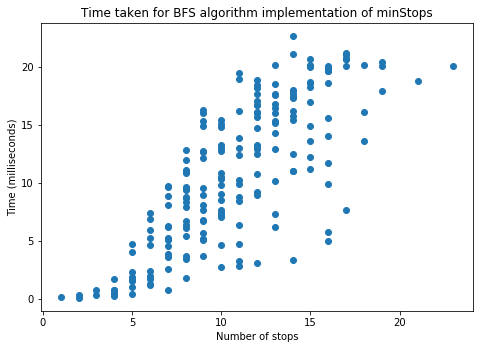

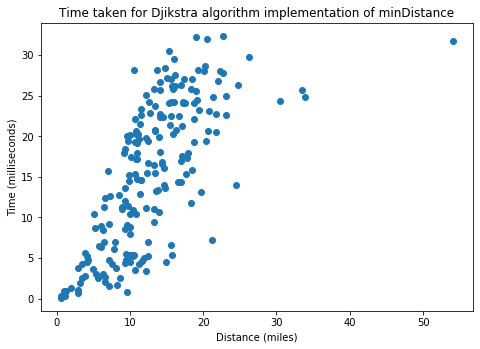

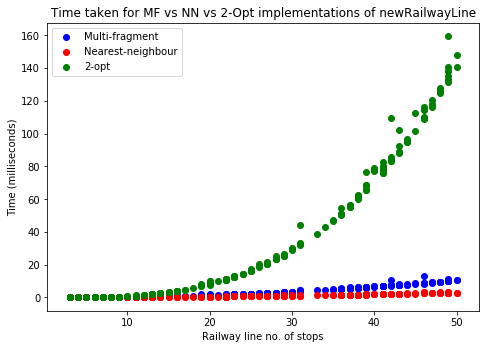

In [32]:
import timeit
import random
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
import matplotlib.pyplot as plt4

l = LondonRailwayMapper(railway_network)
l.loadStationsAndLines()

"""
------Testing the time taken for minStops:
"""
list_of_min_stops = []
list_of_min_stop_times = []
def time_taken_min_stops():
    #------Two hundred random data points are created.
    for _ in range(200):
        start_station = l.graph.station_names[random.randint(0, l.graph.no_of_vertices-1)]
        end_station = l.graph.station_names[random.randint(0, l.graph.no_of_vertices-1)]
        while (end_station == start_station):
            end_station = l.graph.station_names[random.randint(0, l.graph.no_of_vertices-1)]
        
        #------These random generated stations are put through the function and timed.
        t0 = timeit.default_timer()
        no_of_stops = l.minStops(start_station, end_station)
        t1 = timeit.default_timer()

        t_final = (t1-t0)*1000
        list_of_min_stops.append(no_of_stops)
        list_of_min_stop_times.append(t_final)
    
    #------The data points are plotted.
    plt1.figure()
    plt2.axes([0,0,1,1])
    plt1.scatter(list_of_min_stops,list_of_min_stop_times)
    plt1.ylabel('Time (milliseconds)')
    plt1.xlabel('Number of stops')
    plt1.title("Time taken for BFS algorithm implementation of minStops")
    plt1.show()

"""
------Testing the time taken for minDistance:
"""
list_of_min_dist = []
list_of_min_dist_times = []
def time_taken_min_dist():
    #------Two hundred sets of random start and dest stations are created.
    for _ in range(200):
        start_station = l.graph.station_names[random.randint(0, l.graph.no_of_vertices-1)]
        end_station = l.graph.station_names[random.randint(0, l.graph.no_of_vertices-1)]
        while (end_station == start_station):
            end_station = l.graph.station_names[random.randint(0, l.graph.no_of_vertices-1)]
        
        #------These random generated stations are put through the function and timed.
        t0 = timeit.default_timer()
        dist = l.minDistance(start_station, end_station)
        t1 = timeit.default_timer()

        t_final = (t1-t0)*1000
        list_of_min_dist.append(dist)
        list_of_min_dist_times.append(t_final)
    
    #------The data points are plotted.
    plt2.figure()
    plt2.axes([0,0,1,1])
    plt2.scatter(list_of_min_dist,list_of_min_dist_times)
    plt2.ylabel('Time (milliseconds)')
    plt2.xlabel('Distance (miles)')
    plt2.title("Time taken for Djikstra algorithm implementation of minDistance")
    plt2.show()

"""
------Testing and comparing the time complexity Multi-fragment algorithm with the Nearest neighbour algorithm:
------Some parts of the code below have been commented out, see the next multi-line comment for the reason.
"""
list_of_line_stops = []
list_of_times_mf = []
list_of_times_nn = []
list_of_times_to = []
# list_of_lengths_mf = []
# list_of_lengths_nn = []
# list_of_lengths_to = []
def time_taken_line():
    #------Two hundred set of data points are created.
    for _ in range(200):
        list_of_stations = []
        #------The second argument of random.randint() can be changed if more stations are required for the newRailwayLine. 
        number_of_stations_in_line = random.randint(3, 50)
        #------This loop initialises the input station list for the newRailwayLine funciton
        for _ in range(number_of_stations_in_line):
            station = l.graph.station_names[random.randint(0, l.graph.no_of_vertices-1)]
            while station in list_of_stations:
                station = l.graph.station_names[random.randint(0, l.graph.no_of_vertices-1)]
            list_of_stations.append(station)

        #------The functions are times and the corresponding railway line lengths are stored.
        t0 = timeit.default_timer()
        # _,l1 = l.newRailwayLine(list_of_stations)
        l.newRailwayLine(list_of_stations)
        t1 = timeit.default_timer()
        t_final = (t1-t0)*1000

        t2 = timeit.default_timer()
        # _,l2 = l.newRailwayLineTest(list_of_stations)
        l.newRailwayLineTest(list_of_stations)
        t3 = timeit.default_timer()
        t_final1 = (t3-t2)*1000
        
        t4 = timeit.default_timer()
        # _,l3 = l.newRailwayLineTest1(list_of_stations)
        l.newRailwayLineTest1(list_of_stations)
        t5 = timeit.default_timer()
        t_final2 = (t5-t4)*1000
        
        # list_of_lengths_mf.append(l1)
        # list_of_lengths_nn.append(l2)
        # list_of_lengths_to.append(l3)

        list_of_times_mf.append(t_final)
        list_of_times_nn.append(t_final1)
        list_of_times_to.append(t_final2)
        list_of_line_stops.append(number_of_stations_in_line)

    #------The data points are plotted.
    fig = plt3.figure()
    ax = fig.add_axes([0,0,1,1])
    mf = ax.scatter(list_of_line_stops,list_of_times_mf, color='b')
    nn = ax.scatter(list_of_line_stops,list_of_times_nn, color='r')
    to = ax.scatter(list_of_line_stops,list_of_times_to, color='g')
    ax.set_ylabel('Time (milliseconds)')
    ax.set_xlabel('Railway line no. of stops')
    plt3.legend((mf,nn,to),('Multi-fragment', 'Nearest-neighbour', '2-opt'))
    plt3.title("Time taken for MF vs NN vs 2-Opt implementations of newRailwayLine")
    plt3.show()

"""
------Testing and comparing the length of lines created using Multi-fragment algorithm and Nearest neighbour algorithm and 2-Opt:
------For the following function to work, railway_length in the newRailwayLine functions must be returned along
------with the output list of stations.
"""
# def comparing_dist():
#     fig1 = plt4.figure()
#     ax1 = fig1.add_axes([0,0,1,1])
#     mf1 = ax1.scatter(list_of_line_stops,list_of_lengths_mf, color='b')
#     nn1 = ax1.scatter(list_of_line_stops,list_of_lengths_nn, color='r')
#     to1 = ax1.scatter(list_of_line_stops, list_of_lengths_to,color='g')
#     ax1.set_ylabel('Railway line length (miles)')
#     ax1.set_xlabel('Railway line no. of stops')
#     plt4.legend((mf1,nn1,to1),('Multi-fragment', 'Nearest-neighbour', '2-opt'))
#     plt4.title("Line lengths of MF vs NN vs 2-Opt implementation of newRailwayLine")
#     plt4.show()

time_taken_min_stops()
time_taken_min_dist()
time_taken_line()
# comparing_dist()

The cell below exemplifies the test code I will invoke on your submission. Do NOT modify it. 

In [33]:
# DO NOT MODIFY THIS CELL

import timeit
#------The below line is needed for the test code to work and test_railway_network must be passed into the argument of LondonRailwayMapper()
#test_railway_network = WeightedUndirectedGraph()
testMapper = LondonRailwayMapper()



"""  --------IMPORTANT--------
The edges computed in .newRailwayLine are not added to the graph in my implementation, so calling minDistance in lines 54 and 68 of this cell does not compute anything meaningful. Please use the functions that return the railway line length in the newRailwayLine algorithms (for 2-opt: self.best_dist can be called.)
"""

#
# testing the loadStationsAndLines() API 
#
starttime = timeit.default_timer()
testMapper.loadStationsAndLines()
endtime = timeit.default_timer()
print("\nExecution time to load:", round(endtime-starttime,3))

#
# testing the minStops() and minStops() API on a sample of from/to station pairs  
#
fromList = ["Baker Street", "Epping", "Canonbury", "Vauxhall"]
toList = ["North Wembley", "Belsize Park", "Balham", "Leytonstone"]

for i in range(len(fromList)):
    starttime = timeit.default_timer()
    stops = testMapper.minStops(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("\nExecution time minStops:", round(endtime-starttime,3))

    starttime = timeit.default_timer()
    dist = testMapper.minDistance(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("Execution time minDistance:", round(endtime-starttime,3))

    print("From", fromList[i], "to", toList[i], "in", stops, "stops and", dist, "miles")  
    
#
# testing the newRailwayLine() API on a small list of stations  
#
stationsList = ["Queens Park", "Chigwell", "Moorgate", "Swiss Cottage", "Liverpool Street", "Highgate"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))

#
# testing the newRailwayLine() API on a big list of stations  
#
stationsList = ["Abbey Road", "Barbican", "Bethnal Green", "Cambridge Heath", "Covent Garden", "Dollis Hill", "East Finchley", "Finchley Road and Frognal", "Great Portland Street", "Hackney Wick", "Isleworth", "Kentish Town West", "Leyton", "Marble Arch", "North Wembley", "Old Street", "Pimlico", "Queens Park", "Richmond", "Shepherds Bush", "Tottenham Hale", "Uxbridge", "Vauxhall", "Wapping"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))

TypeError: __init__() missing 1 required positional argument: 'graph'